In [ ]:
import pandas as pd
from pandas.tseries.offsets import MonthEnd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
import bluesquare_data_pipelines.access as blsq

%matplotlib inline

In [ ]:
%%capture
pdss_defs = ['PF: Acceptante nouvelle et renouvellement (DIU et implant) - Ver', 'PF: Acceptante nouvelle et renouvellement (oral & inj) - Ver', 
             'Enfant complètement vacciné - Ver', 'Accouchement assisté - Ver','Consultation Prénatale 4ème visite - Ver','Consultation Prénatale 1ère visite - Ver',
             ' Consultation externe (nvx cas)-ver',
             'Consultation Postnatale - Ver','Consultation Externe (nvx cas patient indigent) - plafond 5% - Ver']

snis_defs = ["A 2.1 CPN 1", "A 2.1 CPN 4", "A 3.1 Nouvelle acceptante PF (total)", 'DQI Vaccination complète chez l’enfant de moins d’une année (0-11 mois) CS', 
             'DQI Consultation Post-Natale CS', 'A 2.3 Accouchements par personnel qualifié']

pdss_ids = pdss.dataelement.uid[pdss.dataelement.name.str.contains('|'.join(pdss_defs))]
snis_ids = snis.dataelement.uid[snis.dataelement.name.str.contains('|'.join(snis_defs))]

pdss_extract = pdss.get_data(pdss_ids, pdss.organisationunit.uid)
snis_extract = snis.get_data(snis_ids, snis.organisationunit.uid)

In [ ]:
pdss_extract.dataelementname = pdss_extract.dataelementname.str.lower()
pdss_extract = pdss_extract[(pdss_extract.monthly < "201901") & (pdss_extract.monthly >= "201701") & ~(pdss_extract.monthly.isin(["201703","201704"]))]

snis_extract.dataelementname = snis_extract.dataelementname.str.lower()
snis_extract = snis_extract[(snis_extract.monthly < "201901") & (snis_extract.monthly >= "201701")]

In [ ]:
#pdss_extract = pdss_extract.set_index(["uidlevel2", "uidlevel3","uidorgunit","monthly"])
pdss_extract.value = pdss_extract.value.astype(float)#.astype(int)
snis_extract.value = snis_extract.value.astype(float)#.astype(int)

In [334]:
def select_fosa(data, prop, start_date, end_date, exclude_periods = np.nan):
    n_months = pd.date_range(start = pd.to_datetime(start_date,  format='%Y%m'), end = pd.to_datetime(end_date,  format='%Y%m'), freq="M").nunique()
    if ((len(data) > prop*n_months) & (min(data.monthly) == start_date)):
        return data
    
def fill_missing_covariates(data, list_variables):
    data[list_variables] = data[list_variables].fillna(method="ffill")
    return data

def make_interpolated_dataset(data, start_date, end_date):
    data.monthly = pd.to_datetime(data.monthly,  format='%Y%m') + MonthEnd(1)
    date_list = pd.date_range(start = pd.to_datetime(start_date,  format='%Y%m'), end = pd.to_datetime(end_date,  format='%Y%m'), freq="M").tolist()*len(data.uidorgunit.unique())
    fosa_list = sorted(data.uidorgunit.unique().tolist()*len(set(date_list)))
    expectation = pd.DataFrame({"monthly":date_list, "uidorgunit":fosa_list})
    full_dat = data.merge(expectation, how="right")
    full_dat = full_dat.groupby("uidorgunit").apply(fill_missing_covariates,["uidlevel3","uidlevel2","dataelementid","dataelementname","catcomboid","catcomboname"])
    full_dat = full_dat.set_index(["uidlevel2","uidorgunit","monthly"]).groupby(level=0).value.apply(lambda x : x.interpolate())
    return full_dat

In [ ]:
variables_dict = {"consultation prénatale 4ème visite - ver":"ANC4", "a 2.1 cpn 4":"ANC4",
                  "consultation prénatale 1ère visite - ver":"ANC1", "a 2.1 cpn 1":"ANC1",
                  "consultation postnatale - ver":"PNC", 
                  "enfant complètement vacciné - ver":"fully_immunized_children",
                  "accouchement assisté - ver":"assisted_delivery", "a 2.3 accouchements par personnel qualifié":"assisted_delivery"}

In [372]:
pdss_full_values = pdss_extract.groupby(["dataelementname","uidlevel2","monthly"]).value.apply(sum)
pdss_complete_fosas = pdss_extract.groupby("uidorgunit").apply(select_fosa, 1, "201701","201901")#.reset_index()
pdss_complete_fosas_values = pdss_complete_fosas.groupby(["dataelementname","uidlevel2","monthly"]).value.apply(sum)

In [373]:
pdss_full_values = pdss_full_values.reset_index().merge(pdss.organisationunit[["uid","name"]], left_on="uidlevel2", right_on="uid").set_index(["dataelementname", "name", "monthly"]).rename(variables_dict).drop(["uid","uidlevel2"], axis=1).reset_index()
pdss_complete_fosas_values = pdss_complete_fosas_values.reset_index().merge(pdss.organisationunit[["uid","name"]], left_on="uidlevel2", right_on="uid").set_index(["dataelementname", "name", "monthly"]).rename(variables_dict).drop(["uid","uidlevel2"], axis=1).reset_index()

In [390]:
snis_full_values = snis_extract.groupby(["dataelementname","uidlevel2","monthly"]).value.apply(sum)
snis_interpolated = snis_extract.groupby("dataelementname").apply(make_interpolated_dataset, "201701", "201901")
snis_interpolated_values = snis_interpolated.groupby(level = [0,1,3]).apply(sum)

In [391]:
snis_full_values = snis_full_values.reset_index().merge(snis.organisationunit[["uid","name"]], left_on="uidlevel2", right_on="uid").set_index(["dataelementname", "name", "monthly"]).rename(variables_dict).drop(["uid","uidlevel2"], axis=1).reset_index()
snis_interpolated_values = snis_interpolated_values.reset_index().merge(snis.organisationunit[["uid","name"]], left_on="uidlevel2", right_on="uid").set_index(["dataelementname", "name", "monthly"]).rename(variables_dict).drop(["uid","uidlevel2"], axis=1).reset_index()

In [418]:
pdss_full_values.name = pdss_full_values.name.str.replace(" DPS","").str.strip()
pdss_complete_fosas_values.name = pdss_complete_fosas_values.name.str.replace(" DPS","").str.strip()
snis_full_values.name = snis_full_values.name.str.replace(" Province","").str.strip()
snis_interpolated_values.name = snis_interpolated_values.name.str.replace(" Province","").str.strip()

In [419]:
pdss_full_values.monthly = pd.to_datetime(pdss_full_values.monthly,  format='%Y%m') + MonthEnd(1)
pdss_complete_fosas_values.monthly = pd.to_datetime(pdss_complete_fosas_values.monthly,  format='%Y%m') + MonthEnd(1)
snis_full_values.monthly = pd.to_datetime(snis_full_values.monthly,  format='%Y%m') + MonthEnd(1)

In [420]:
compiled_data = pdss_full_values.merge(pdss_complete_fosas_values, on=["name","monthly","dataelementname"],
                                       how = "outer").merge(snis_full_values, on=["name","monthly","dataelementname"], how = "outer").merge(snis_interpolated_values, on=["name","monthly","dataelementname"], how = "outer")

In [424]:
compiled_data.columns = ["dataelementname", "province", "month", "pdss_complete", "pdss_evolution", "snis_raw", "snis_interpolated"]
compiled_data = compiled_data[compiled_data.dataelementname.isin(["ANC4", "ANC1", "assisted_delivery"])]

In [447]:
print(compiled_data[(compiled_data.month.dt.year == 2018)].groupby(["dataelementname"]).apply(lambda x: x.pdss_complete.sum() / x.snis_raw.sum()))
print(compiled_data[(compiled_data.month.dt.year == 2018)].groupby(["dataelementname"]).apply(lambda x: x.pdss_complete.sum() / x.snis_interpolated.sum()))

dataelementname
ANC1                 0.123462
ANC4                 0.127544
assisted_delivery    0.175228
dtype: float64
dataelementname
ANC1                 0.104852
ANC4                 0.099667
assisted_delivery    0.152619
dtype: float64


In [448]:
pdss_provinces = ["eq Equateur", "hk Haut Katanga", "hl Haut Lomami","ll Lualaba" , "mg Mongala", "mn Maniema", "nk Nord Kivu", "sk Sud Kivu", "su Sud Ubangi", "tu Tshuapa"]

print(compiled_data[(compiled_data.month.dt.year == 2018) & (compiled_data.province.isin(pdss_provinces))].groupby(["dataelementname", "province"]).apply(lambda x: x.pdss_complete.sum() / x.snis_raw.sum()))
print(compiled_data[(compiled_data.month.dt.year == 2018)& (compiled_data.province.isin(pdss_provinces))].groupby(["dataelementname", "province"]).apply(lambda x: x.pdss_complete.sum() / x.snis_interpolated.sum()))

dataelementname    province       
ANC1               eq Equateur        0.438073
                   hk Haut Katanga    0.118981
                   hl Haut Lomami     0.214186
                   ll Lualaba         0.269582
                   mg Mongala         0.437552
                   mn Maniema         0.116725
                   nk Nord Kivu       0.139380
                   sk Sud Kivu        0.122300
                   su Sud Ubangi      0.281334
                   tu Tshuapa         0.610666
ANC4               eq Equateur        0.350320
                   hk Haut Katanga    0.169913
                   hl Haut Lomami     0.136366
                   ll Lualaba         0.246733
                   mg Mongala         0.463845
                   mn Maniema         0.114534
                   nk Nord Kivu       0.235478
                   sk Sud Kivu        0.222678
                   su Sud Ubangi      0.240391
                   tu Tshuapa         0.503639
assisted_delivery  eq Equ

With the Programme de Développement du Système de Santé (PDSS), Results Based Funding (RBF) is playing an important role in the evolution of service provision in the DRC. In 2018, we estimate that around 15% of deliveries in the country were provided through PDSS funded facilities, as well as around 10% of ANC visits. When looking to provinces in which the PDSS is implemented, this proportion gets even higher. We estimated that PDSS funds well over 50% of assisted deliveries in the Equateur and Tshuapa provinces and over a third of first ANC visits in those provinces and the Mongala Province. 

Figure 1 also shows how this share of RBF funded service provision has rapidly grown in 2017, and has then followed a somewhat slower growth in 2018. 

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in double_scalars
  after removing the cwd from sys.path.
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in double_scalars
  after removing the cwd from sys.path.
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in double_scalars
  
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in double_scalars
  


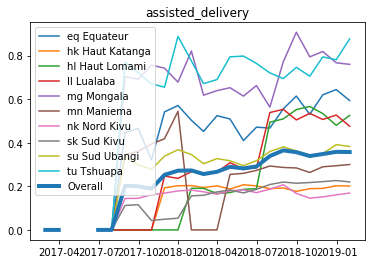

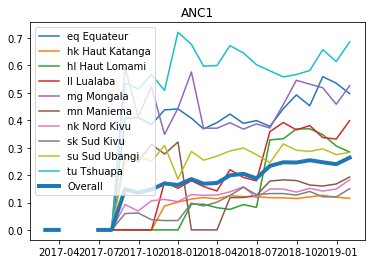

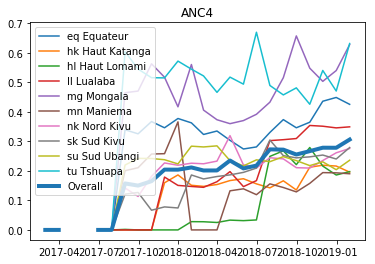

In [484]:
for serie in compiled_data.dataelementname.unique():
    fig1 = plt.figure()
    dat_p = compiled_data[(compiled_data.dataelementname == serie) & (compiled_data.province.isin(pdss_provinces))]
    dat_p2 = dat_p.groupby(["province", "month"]).apply(lambda x: x.pdss_complete.sum()/x.snis_raw.sum()).reset_index()
    dat_p2 = dat_p2.rename({0:"value"}, axis = 1)
    for province in pdss_provinces:
        plt.plot(dat_p2.loc[dat_p2.province == province,"month"],dat_p2.loc[dat_p2.province == province,"value"], label = province)
    dat_pn = dat_p.groupby(["month"]).apply(lambda x: x.pdss_complete.sum()/x.snis_raw.sum()).reset_index()
    dat_pn = dat_pn.rename({0:"value"}, axis = 1)
    plt.plot(dat_pn.month,dat_pn.value, label = "Overall", linewidth = 4)
    plt.legend()
    plt.title(serie)

This trend is due to two phenomenons. First, as shown in figure 2, we see a slow growth in service provision at national level. At national level, assisted delivery as increased by 16% between january 2017 and december 2018. ANC1 has remained at the same levels, and ANC4 has increased 12%. By comparison, in facilities that started the RBF program in early 2017, we see a 73% increase in the number of assisted delivery a 58% increase in ANC1 attendance and a doubling of ANC4 attendance. 

The augmentation of the share of RBF funded service delivery is thus due to a dual phenomenon: a progressive extension of the number of the number of zones included in the RBF program, and an increase in service delivery in the selected facilities.

assisted_delivery : 1.1638080124489159
ANC1 : 1.009251892618991
ANC4 : 1.1221933822373857


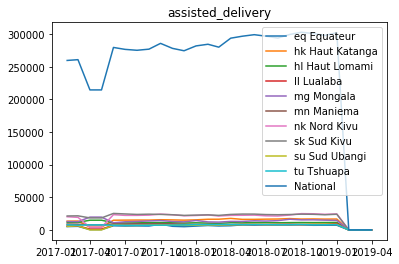

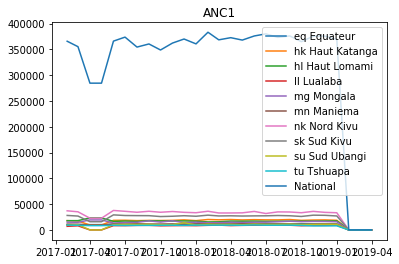

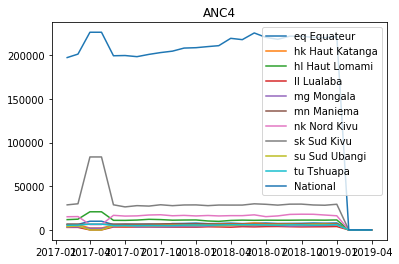

In [478]:
for serie in compiled_data.dataelementname.unique():
    fig1 = plt.figure()
    dat_p = compiled_data[(compiled_data.dataelementname == serie)]
    dat_p2 = dat_p.groupby(["province", "month"]).apply(lambda x: x.snis_interpolated.sum()).reset_index()
    dat_p2 = dat_p2.rename({0:"value"}, axis = 1)
    for province in pdss_provinces:
        plt.plot(dat_p2.loc[dat_p2.province == province,"month"],dat_p2.loc[dat_p2.province == province,"value"], label = province)
    dat_pn = dat_p.groupby(["month"]).apply(lambda x: x.snis_interpolated.sum()).reset_index()
    dat_pn = dat_pn.rename({0:"value"}, axis = 1)
    print(serie + " : " + str(dat_pn.value[dat_pn.month == "2018-12-31"].iloc[0] / dat_pn.value[dat_pn.month == "2017-01-31"].iloc[0]))
    plt.plot(dat_pn.month,dat_pn.value, label = "National")
    plt.legend()
    plt.title(serie)

In [483]:
for serie in compiled_data.dataelementname.unique():
    dat_pn = compiled_data[compiled_data.dataelementname == serie].groupby(["month"]).apply(lambda x: x.pdss_evolution.sum()).reset_index()
    dat_pn = dat_pn.rename({0:"value"}, axis = 1)
    print(serie + " : " + str(dat_pn.value[dat_pn.month == "2018-12-31"].iloc[0] / dat_pn.value[dat_pn.month == "2017-04-30"].iloc[0]))

assisted_delivery : 1.732620320855615
ANC1 : 1.5818870784388026
ANC4 : 2.1449134724243892
